In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"youssefmahmoud2000","key":"82786d5c65e1f6cae466ff2541bd5ad9"}'}

In [ ]:
! mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d techsash/waste-classification-data

 93% 397M/427M [00:02<00:00, 225MB/s]
100% 427M/427M [00:02<00:00, 161MB/s]


In [ ]:
!unzip waste-classification-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

In [ ]:
# Define paths to your dataset in Google Drive
train_dir = '/content/DATASET/TRAIN'
test_dir = '/content/DATASET/TEST'

# Image size and batch size
img_size = (224, 224)
batch_size = 50
validation_split = 0.2
# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split  # Set the validation split
)



In [ ]:
# Normalization for test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_data = val_datagen.flow_from_directory(
    directory=train_dir,  # Use the same training directory
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation' ) # Set the subset as 'valid


Found 18052 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


In [ ]:
# Load pre-trained MobileNetV2 without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
from keras.optimizers import Adam
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_data,
    callbacks=[early_stop]
)

Epoch 1/10
362/362 [==============================] - 244s 649ms/step - loss: 0.5279 - accuracy: 0.7420 - val_loss: 0.3854 - val_accuracy: 0.8728
Epoch 2/10
362/362 [==============================] - 231s 638ms/step - loss: 0.3309 - accuracy: 0.8734 - val_loss: 0.2716 - val_accuracy: 0.9131
Epoch 3/10
362/362 [==============================] - 232s 642ms/step - loss: 0.2747 - accuracy: 0.8979 - val_loss: 0.2293 - val_accuracy: 0.9224
Epoch 4/10
362/362 [==============================] - 230s 636ms/step - loss: 0.2489 - accuracy: 0.9057 - val_loss: 0.2137 - val_accuracy: 0.9264
Epoch 5/10
362/362 [==============================] - 236s 652ms/step - loss: 0.2300 - accuracy: 0.9133 - val_loss: 0.2035 - val_accuracy: 0.9269
Epoch 6/10
362/362 [==============================] - 230s 635ms/step - loss: 0.2201 - accuracy: 0.9167 - val_loss: 0.1982 - val_accuracy: 0.9282
Epoch 7/10
362/362 [==============================] - 231s 637ms/step - loss: 0.2107 - accuracy: 0.9197 - val_loss: 0.1946 -

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions on test data
predictions = model.predict(test_generator)
predicted_classes = np.round(predictions)

# Generate confusion matrix
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
conf_matrix = tf.math.confusion_matrix(true_classes, predicted_classes)

51/51 [==============================] - 5s 103ms/step - loss: 0.3312 - accuracy: 0.8456
Test accuracy: 0.8456028699874878
51/51 [==============================] - 6s 102ms/step


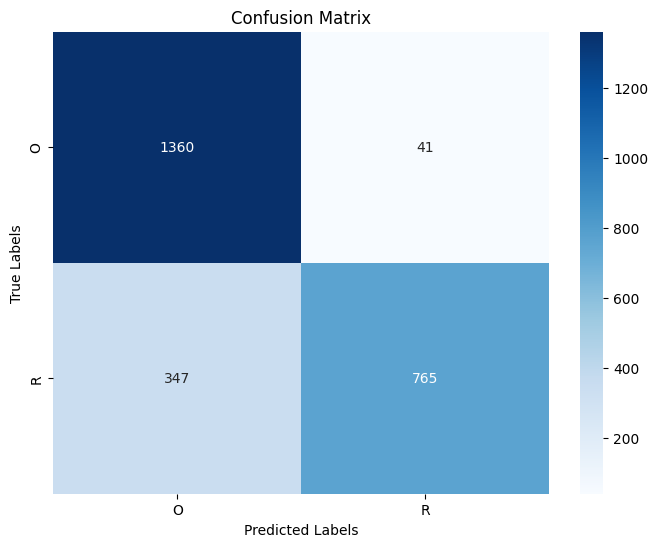

In [ ]:
# Visualize confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


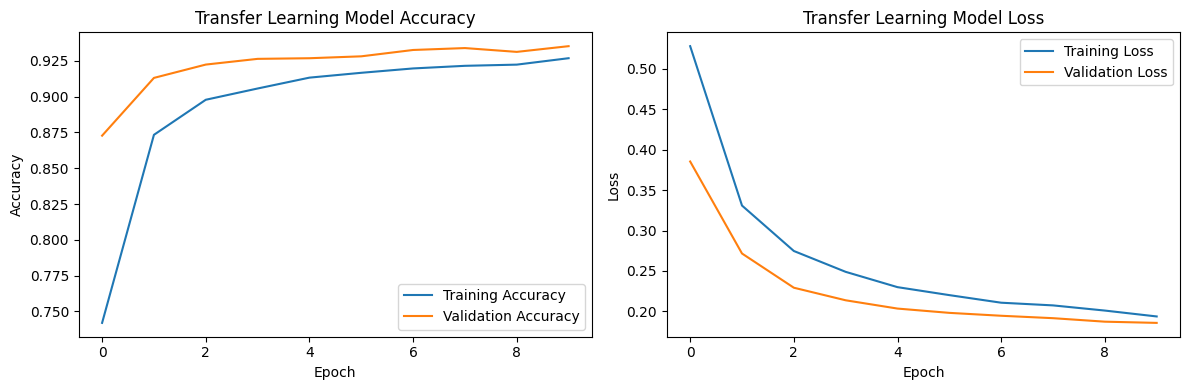

In [ ]:
# Plot performance curves (accuracy and loss) for Transfer Learning model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-20-50a90829efb8>:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, i + 1)


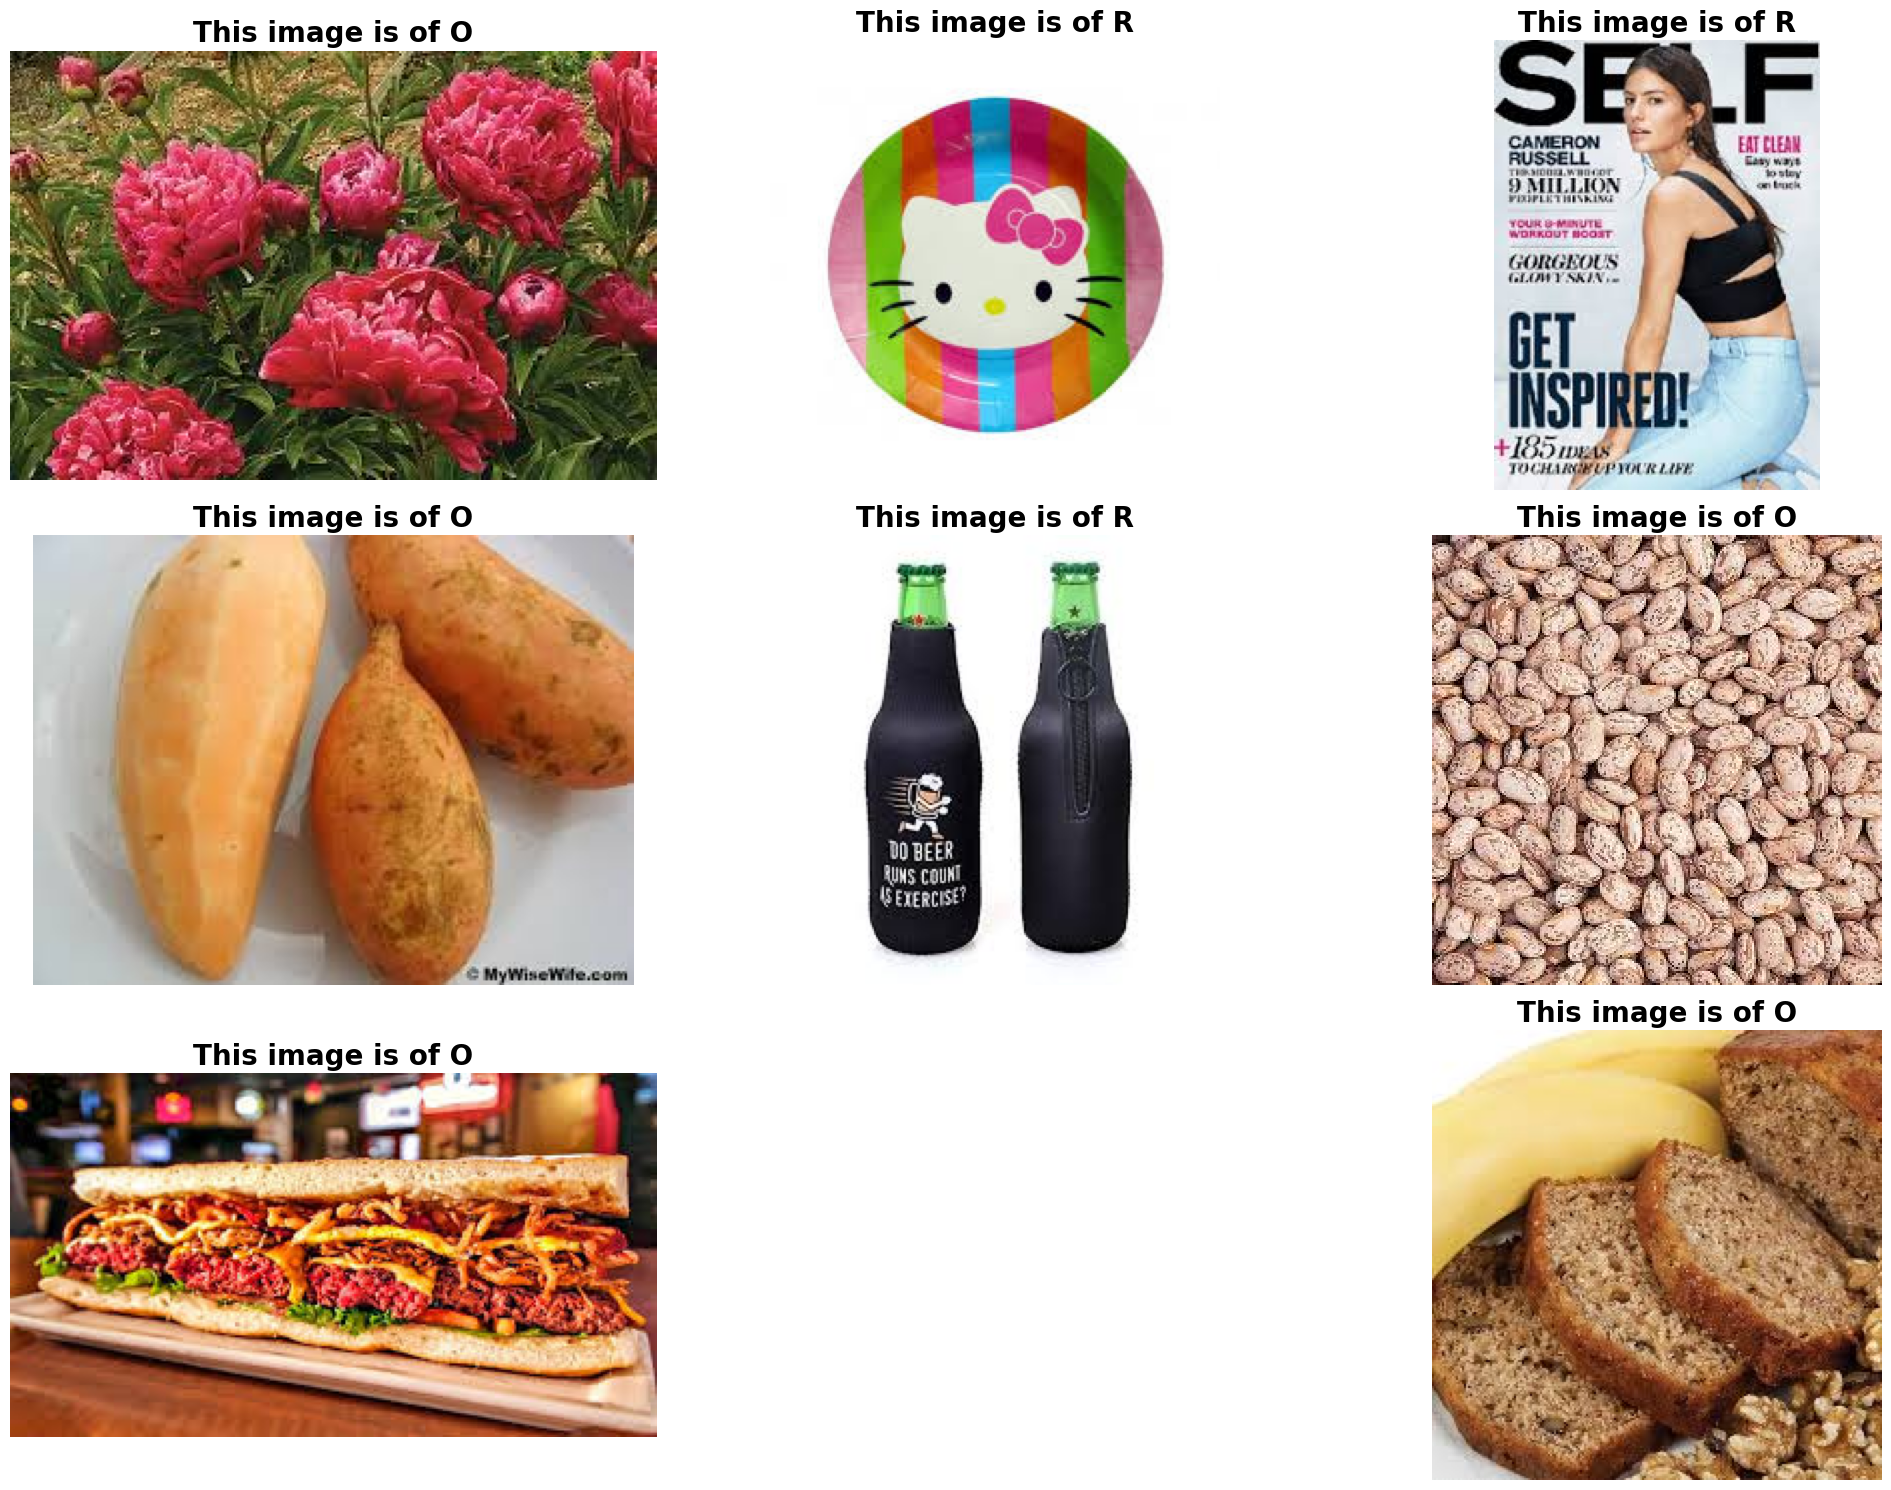

In [ ]:
import pandas as pd
import os
from PIL import Image

# Specify the paths to your training and testing data directories
train_data_dir = "/content/DATASET/TRAIN"
test_data_dir = "/content/DATASET/TEST"

# Define the function to load images and labels into a DataFrame
def load_images_and_labels(data_dir):
    image_data = []
    labels = []
    label_names = os.listdir(data_dir)

    for label_name in label_names:
        label_path = os.path.join(data_dir, label_name)
        if os.path.isdir(label_path):
            label = label_name
            for filename in os.listdir(label_path):
                if filename.endswith(('.png', '.jpg')):
                    image_path = os.path.join(label_path, filename)
                    image = Image.open(image_path)
                    image_data.append(np.array(image))
                    labels.append(label)

    return pd.DataFrame({'image': image_data, 'label': labels})

# Load training and testing data into DataFrames
train_data = load_images_and_labels(train_data_dir)
test_data = load_images_and_labels(test_data_dir)

# Display random images with labels
plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    index = np.random.randint(len(train_data))
    plt.title('This image is of {0}'.format(train_data['label'][index]),
              fontdict={'size': 20, 'weight': 'bold'})
    plt.imshow(train_data['image'][index].astype('uint8'))
    plt.axis('off')  # Turn off axis
    plt.tight_layout()

plt.show()


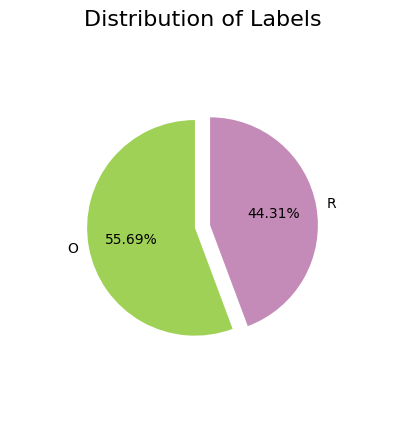

In [ ]:
plt.figure(figsize=(10, 5))

# Pie chart showing the distribution of labels
colors = ['#a0d157', '#c48bb8']
plt.pie(train_data['label'].value_counts(), startangle=90, explode=[0.05, 0.05], autopct='%0.2f%%',
        labels=train_data['label'].value_counts().index, colors=colors, radius=0.7)
plt.title('Distribution of Labels', fontsize=16)



# Display the plot
plt.show()

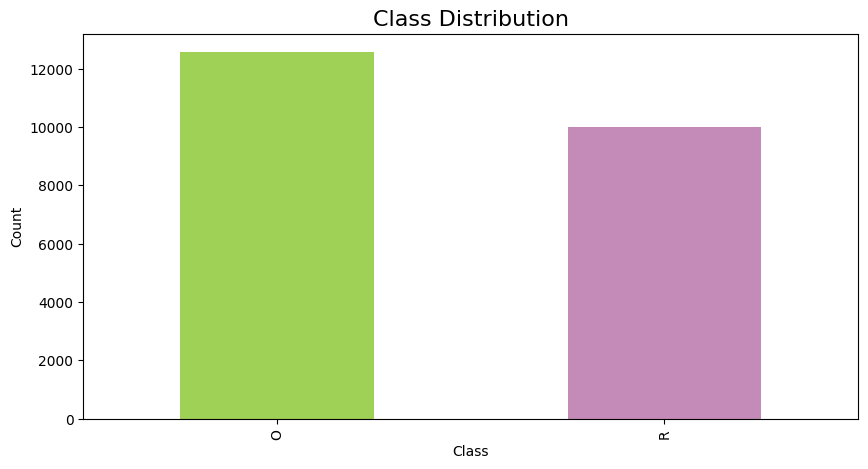

In [ ]:
# Bar chart showing the distribution of labels
plt.figure(figsize=(10, 5))
train_data['label'].value_counts().plot(kind='bar', color=colors)
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Get classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           O       0.80      0.97      0.88      1401
           R       0.95      0.69      0.80      1112

    accuracy                           0.85      2513
   macro avg       0.87      0.83      0.84      2513
weighted avg       0.86      0.85      0.84      2513

